# Credit Markets
## FINM 35700 - Spring 2024

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

# Basic Usage of QuantLib analytics library
## More details at: https://quantlib-python-docs.readthedocs.io/en/latest/

- 1\. Objects and Handles
  - a. Define a quote object and inspect the value
  - b. Define quoteHandle as a handle/smart pointer to the quote object    
  - c. Calendars and day-count conventions
- 2\. Cashflow Schedules
  - a. Construct semi-annual cashflow schedule object, for fixed-rate bonds
  - b. Inspect the semi-annual cashflow schedule
  - c. Construct quarterly cashflow schedule object, for floating-rate bonds
  - d. Inspect the quarterly cashflow schedule
- 3\. Discount Curve / Yield Curve Term Structure
  - a. Constructing a Flat Yield Curve
  - b. Inspect the discount curve
- 4\. Fixed and Floating Rate Bonds
  - a. Constructing a fixed rate bond object
  - b. Investigate the fixed-rate bond cash-flows
  - c. Constructing a floating rate bond object: linked to SOFR index
- 5\. Bond Present Value Calculation (no credit risk)
  - a. Direct function call using risk-free bond pricing engine
  - b. Manual Calculation to validate PV (for fixed and floating-rate bonds)
  - c. Bond Clean vs Dirty Prices (adjusted to settle date)
- 6\. Market Data Scenarios
  - a. Apply +/-1bp parallel shift scenarios in interest rates curve and compute scenario prices
  - b. Compute scenario DV01, duration and convexity
  - c. Yield to Price conversions
  - d. Price to Yield conversions
- 7\. Analytical Duration, Convexity and Z-Spread (flat yield model)
  - a. Compute bond duration, convexity and Z-Spread   
  - b. Validate Z-Spread
- 8\. Treasury Yield Curve Calibration (via Bootstrapping)
  - a. Calibrate treasury flat yield curve (simple case of one calibration instrument)
  - b. Display the calibrated Treasury discount curve dataframe
  - c. Plot the calibrated Treasury Zero Rates and Discount Factors curves
  - d. Reprice the bond on the yield curve to validate the calibration

In [100]:
import QuantLib as ql
import numpy as np
import pandas as pd

# 1. Objects and Handles
## a. Define a quote object and inspect the value.

In [101]:
quote = ql.SimpleQuote(.01)
print(quote.value())

quote.setValue(.02)
print(quote.value())

0.01
0.02


## b. Define quoteHandle as a handle/smart pointer to the quote object

In [102]:
quoteHandle = ql.QuoteHandle(quote)
quoteHandle.value()

0.02

### When the quote object is changed, the quoteHandle changes value as well

In [103]:
quote.setValue(.03)
quoteHandle.value()

0.03

## c. Calendars and day-count conventions

In [104]:
# dates
todays_date = ql.Date.todaysDate()
test_date = todays_date + 90
print('todays_date =', todays_date)
print('test_date =', test_date)


# calendars
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
holiday_list = list(calendar.holidayList(todays_date, test_date))
print('holiday_list =', holiday_list)


# day count conventions
day_count = ql.Actual360()
print('day_count =', day_count)

# year fractions
test_year_fraction = day_count.yearFraction(todays_date, test_date)
print('Year Fraction  from', todays_date, 'to', test_date,'] =', test_year_fraction)

todays_date = March 17th, 2024
test_date = June 15th, 2024
holiday_list = [Date(29,3,2024), Date(27,5,2024)]
day_count = Actual/360 day counter
Year Fraction  from March 17th, 2024 to June 15th, 2024 ] = 0.25


# 2. Cashflow Schedules
## a. Construct semi-annual cashflow schedule object, for fixed-rate bonds

In [105]:
issue_date = ql.Date(2, 4, 2024)        # 2024-04-02
maturity_date = ql.Date(2, 4, 2028)     # 2028-04-02
coupon_freq = ql.Semiannual
coupon_term = ql.Period(coupon_freq)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
day_count_conv = ql.Unadjusted
date_generation = ql.DateGeneration.Backward
month_end = True

# fixed_rate_schedule
fixed_rate_schedule = ql.Schedule(issue_date,
                       maturity_date,
                       coupon_term,
                       calendar,
                       day_count_conv,
                       day_count_conv,
                       date_generation,
                       month_end)

## b. Inspect the semi-annual cashflow schedule
- Use list() to get a list of all the dates in Schedule, and len() to get number of dates
- Use ] for random access
- use startDate(), endDate()

In [106]:
print("All dates: ", list(fixed_rate_schedule))
print("Length: ", len(fixed_rate_schedule))
print("The 3rd coupon date: ", [fixed_rate_schedule])  # random access
print("Start Date: ", fixed_rate_schedule.startDate())
print("End Date: ", fixed_rate_schedule.endDate())

All dates:  [Date(2,4,2024), Date(2,10,2024), Date(2,4,2025), Date(2,10,2025), Date(2,4,2026), Date(2,10,2026), Date(2,4,2027), Date(2,10,2027), Date(2,4,2028)]
Length:  9
The 3rd coupon date:  [<QuantLib.QuantLib.Schedule; proxy of <Swig Object of type 'Schedule *' at 0x0000023BD05A1BA0> >]
Start Date:  April 2nd, 2024
End Date:  April 2nd, 2028


## c. Construct quarterly cashflow schedule object, for floating-rate bonds

In [107]:
# floating_rate_bond_schedule
floating_rate_schedule = ql.Schedule(
    issue_date,
    maturity_date,
    ql.Period(ql.Quarterly),
    calendar,
    day_count_conv,
    day_count_conv,
    date_generation,
    month_end,
)

## d. Inspect the quarterly cashflow schedule

In [108]:
print("All dates: ", list(floating_rate_schedule))
print("Length: ", len(floating_rate_schedule))
print("Start Date: ", fixed_rate_schedule.startDate())
print("End Date: ", fixed_rate_schedule.endDate())

All dates:  [Date(2,4,2024), Date(2,7,2024), Date(2,10,2024), Date(2,1,2025), Date(2,4,2025), Date(2,7,2025), Date(2,10,2025), Date(2,1,2026), Date(2,4,2026), Date(2,7,2026), Date(2,10,2026), Date(2,1,2027), Date(2,4,2027), Date(2,7,2027), Date(2,10,2027), Date(2,1,2028), Date(2,4,2028)]
Length:  17
Start Date:  April 2nd, 2024
End Date:  April 2nd, 2028


# 3. Discount Curve / Yield Curve Term Structure
## a. Constructing a Flat Yield Curve

In [109]:
# Set the static valuation date: 2024-04-02
calc_date = ql.Date(2, 4, 2024)
ql.Settings.instance().evaluationDate = calc_date

# using 5% flat interest rate for testing
flat_rate = ql.SimpleQuote(0.05)
rate_handle = ql.QuoteHandle(flat_rate)
day_count = ql.Actual360()
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
continuous_comp = ql.Continuous # continously compounded rate of 5%
flat_yield_curve = ql.FlatForward(calc_date, rate_handle, day_count, continuous_comp)
flat_yield_curve_handle = ql.YieldTermStructureHandle(flat_yield_curve)

## b. Inspect the discount curve

In [110]:
ref_date = flat_yield_curve.referenceDate()
test_date = ql.Date(30, 6, 2025)

# calc year fraction between ref_date and test_date
yearFrac = flat_yield_curve.dayCounter().yearFraction(ref_date, test_date)

print("Reference Date =", ref_date)
print("Test Date =", test_date)
print("Year Fraction between Reference Date and Test Date : ", yearFrac)
print("Discount Factor for Test Date", test_date, ": ", flat_yield_curve.discount(test_date))
print("custom DF calculation for Test Date", test_date, ": ", np.exp(-flat_rate.value() * yearFrac))
print("Difference in Discount Factor:", flat_yield_curve.discount(test_date) - np.exp(-flat_rate.value() * yearFrac))



Reference Date = April 2nd, 2024
Test Date = June 30th, 2025
Year Fraction between Reference Date and Test Date :  1.261111111111111
Discount Factor for Test Date June 30th, 2025 :  0.9388913116117773
custom DF calculation for Test Date June 30th, 2025 :  0.9388913116117772
Difference in Discount Factor: 1.1102230246251565e-16


# 4. Fixed and Floating Rate Bonds
## a. Constructing a fixed rate bond object

In [111]:
# day_count: ACT/ACT for Govt bonds
day_count_govt = ql.ActualActual(ql.ActualActual.ISMA)

# day_count: 30/360 for fixed-rate Corp bonds
day_count_corp_fixed = ql.Thirty360(ql.Thirty360.USA)

# day_count: ACT/360 for floating-rate bonds
day_count_floater = ql.Actual360()


# settlement_days: 1 for Govt bonds
settlement_days_govt = 1

# settlement_days: 2 for Corp Bonds
settlement_days_corp = 2

# Govt Bonds specs
day_count = day_count_govt
settlement_days = settlement_days_govt

# coupons
coupon_rate = 0.04
coupons = [coupon_rate]

# payment_convention
payment_convention = ql.Unadjusted

# face_value
face_value = 100


# Construct the fixed_rate_bond
face_value = 100
fixed_rate_bond = ql.FixedRateBond(
    settlement_days,
    face_value,
    fixed_rate_schedule,
    coupons,
    day_count,
    payment_convention)

## b. Investigate the fixed-rate bond cash-flows

In [112]:
x = [(cf.date(), cf.amount()) for cf in fixed_rate_bond.cashflows()]
cf_date_fixed, cf_amount = zip(*x)
cf_frame_fixed = pd.DataFrame(data={'CashFlowDate': cf_date_fixed, 'CashFlowAmount': cf_amount})
print(cf_frame_fixed)

        CashFlowDate  CashFlowAmount
0  October 2nd, 2024             2.0
1    April 2nd, 2025             2.0
2  October 2nd, 2025             2.0
3    April 2nd, 2026             2.0
4  October 2nd, 2026             2.0
5    April 2nd, 2027             2.0
6  October 2nd, 2027             2.0
7    April 2nd, 2028             2.0
8    April 2nd, 2028           100.0


## c. Constructing a floating rate bond object: linked to SOFR index

In [113]:
# sofr_term_structure_handle: using 5% flat interest rate for testing
rate_handle = ql.QuoteHandle(ql.SimpleQuote(5/100))
sofr_term_structure = ql.FlatForward(calc_date, rate_handle, day_count_floater, ql.Continuous)
sofr_term_structure_handle = ql.YieldTermStructureHandle(sofr_term_structure)

# Set SOFR index history
im = ql.IndexManager.instance()
sofr_index = ql.Sofr(sofr_term_structure_handle)

# Set SOFR fixings
im.clearHistory(sofr_index.name())
sofr_index.addFixing(ql.Date(28, ql.March, 2024), 5/100)
sofr_index.addFixing(ql.Date(1, ql.April, 2024), 5/100)


# floating_rate_bond
floating_rate_bond = ql.FloatingRateBond(settlement_days,
                                face_value,
                                floating_rate_schedule,
                                sofr_index,
                                day_count_floater,
                                payment_convention,
                                spreads=[25/10000], # 25 bps floating rate
                                issueDate=issue_date)


In [114]:
x = [(cf.date(), cf.amount()) for cf in floating_rate_bond.cashflows()]
cf_date_float, cf_amount = zip(*x)
cf_frame_float = pd.DataFrame(data={'CashFlowDate': cf_date_float, 'CashFlowAmount': cf_amount})
print(cf_frame_float)

         CashFlowDate  CashFlowAmount
0      July 2nd, 2024        1.335104
1   October 2nd, 2024        1.349865
2   January 2nd, 2025        1.349865
3     April 2nd, 2025        1.320345
4      July 2nd, 2025        1.335104
5   October 2nd, 2025        1.349865
6   January 2nd, 2026        1.349865
7     April 2nd, 2026        1.320345
8      July 2nd, 2026        1.335104
9   October 2nd, 2026        1.349865
10  January 2nd, 2027        1.350044
11    April 2nd, 2027        1.320520
12     July 2nd, 2027        1.335104
13  October 2nd, 2027        1.350044
14  January 2nd, 2028        1.350044
15    April 2nd, 2028        1.335370
16    April 2nd, 2028      100.000000


# 5. Bond Present Value Calculation (no credit risk)
## a. Direct function call using risk-free bond pricing engine

In [115]:
# fixed_rate_bond PV
bond_engine = ql.DiscountingBondEngine(flat_yield_curve_handle)
fixed_rate_bond.setPricingEngine(bond_engine)
fixed_rate_bond_pv = fixed_rate_bond.NPV()
print('fixed_rate_bond_pv =', fixed_rate_bond_pv)

# floating_rate_bond PV
floating_rate_bond.setPricingEngine(bond_engine)
floating_rate_bond_pv = floating_rate_bond.NPV()
print('floating_rate_bond_pv =', floating_rate_bond_pv)

fixed_rate_bond_pv = 95.93321956659715
floating_rate_bond_pv = 100.91327849916414


## b. Manual Calculation to validate PV (for fixed and floating-rate bonds)

In [116]:
# Validate fixed-rate bond PV
used_cf_frame = cf_frame_fixed
used_bond_pv = fixed_rate_bond_pv

# Validate floating-rate bond PV
discount_yearfrac = np.zeros((len(used_cf_frame,)))
discount_factor = np.zeros((len(used_cf_frame,)))

i = 0
for cf_date in used_cf_frame['CashFlowDate']:
    discount_yearfrac[i] = flat_yield_curve.dayCounter().yearFraction(flat_yield_curve.referenceDate(), cf_date)
    discount_factor[i] = flat_yield_curve.discount(cf_date)
    i += 1

used_cf_frame['YearFrac'] = discount_yearfrac
used_cf_frame['DiscountFactor'] = discount_factor
used_cf_frame['NPV'] = used_cf_frame['CashFlowAmount'] * used_cf_frame['DiscountFactor']

used_cf_frame

,CashFlowDate,CashFlowAmount,YearFrac,DiscountFactor,NPV
0,"October 2nd, 2024",2.0,0.508333,0.974904,1.949807
1,"April 2nd, 2025",2.0,1.013889,0.950569,1.901138
2,"October 2nd, 2025",2.0,1.522222,0.926713,1.853426
3,"April 2nd, 2026",2.0,2.027778,0.903582,1.807163
4,"October 2nd, 2026",2.0,2.536111,0.880905,1.761810
5,"April 2nd, 2027",2.0,3.041667,0.858917,1.717833
6,"October 2nd, 2027",2.0,3.550000,0.837361,1.674722
7,"April 2nd, 2028",2.0,4.058333,0.816346,1.632693
8,"April 2nd, 2028",100.0,4.058333,0.816346,81.634627


In [117]:
pv_manual = used_cf_frame['NPV'].sum()
print('NPV engine = ', used_bond_pv)
print('NPV manual = ', pv_manual)
print('NPV diff = ', pv_manual - used_bond_pv)

NPV engine =  95.93321956659715
NPV manual =  95.93321956659715
NPV diff =  0.0


## c. Bond Clean vs Dirty Prices (adjusted to settle date)

In [118]:
print('Bond Notional = ', fixed_rate_bond.notional())
print('Settle Date = ', fixed_rate_bond.settlementDate())
print('Discount Factor to Settle Date = ', round(flat_yield_curve_handle.discount(fixed_rate_bond.settlementDate()), 4))
print('Bond NPV (Calc Date) = ', round(fixed_rate_bond.NPV(), 4))
print('Bond NPV Adjusted to Settle Date = ', round(fixed_rate_bond.NPV() / flat_yield_curve_handle.discount(fixed_rate_bond.settlementDate()), 4))
print('Bond Dirty Price = ', round(fixed_rate_bond.dirtyPrice(), 4))
print('Bond Clean Price = ', round(fixed_rate_bond.cleanPrice(), 4))
print('Bond Accrued = ', round(fixed_rate_bond.accruedAmount(), 4))


Bond Notional =  100.0
Settle Date =  April 3rd, 2024
Discount Factor to Settle Date =  0.9999
Bond NPV (Calc Date) =  95.9332
Bond NPV Adjusted to Settle Date =  95.9465
Bond Dirty Price =  95.9465
Bond Clean Price =  95.9356
Bond Accrued =  0.0109


# 6. Market Data Scenarios
## a. Apply +/-1bp parallel shift scenarios in interest rates curve and compute scenario prices

In [119]:
# start with interest_rate_bump = 0
interest_rate_bump = ql.SimpleQuote(0.0)
flat_yield_curve_bumped = ql.ZeroSpreadedTermStructure(flat_yield_curve_handle, ql.QuoteHandle(interest_rate_bump))

bond_engine = ql.DiscountingBondEngine(ql.YieldTermStructureHandle(flat_yield_curve_bumped))
fixed_rate_bond.setPricingEngine(bond_engine)

price_base = fixed_rate_bond.cleanPrice()

# Original price (zero interest rate bump)
print("Price (base case): ", round(price_base, 4))

# Bump interest rate by +1bps (parallel shift)
interest_rate_bump.setValue(0.0001)
price_up_1bp = fixed_rate_bond.cleanPrice()
print("Price in +1bps scenario: ", round(price_up_1bp, 4))
print("Price diff in +1bps scenario: ", round(price_up_1bp - price_base, 6))

# Bump interest rate by -1bps (parallel shift)
interest_rate_bump.setValue(-0.0001)
price_down_1bp = fixed_rate_bond.cleanPrice()
print("Price for -1bps scenario:", round(price_down_1bp, 4))
print("Price diff in -1bps scenario: ", round(price_down_1bp - price_base, 6))

 # Remove interest rate bump
interest_rate_bump.setValue(0)



Price (base case):  95.9356
Price in +1bps scenario:  95.8993
Price diff in +1bps scenario:  -0.036268
Price for -1bps scenario: 95.9719
Price diff in -1bps scenario:  0.036283


 ## b. Compute scenario DV01, duration and convexity

In [120]:
# Compute scenario delta/gamma sensitivities
dv01 = round((price_down_1bp - price_base) * 1e4 / 100, 4)
duration = round(dv01 / fixed_rate_bond.dirtyPrice() * 100, 4)
gamma_1bp = (price_down_1bp - 2*price_base + price_up_1bp) * 1e8 / 100
convexity = round(gamma_1bp / fixed_rate_bond.dirtyPrice() * 100, 4)

print("DV01: ", dv01)
print("Duration: ", duration)
print("Convexity: ", convexity)




DV01:  3.6283
Duration:  3.7816
Convexity:  14.9262


## c. Yield to Price conversions


In [121]:
# Use original interest rate yield of 5%
# flat_rate.setValue(0.05)
print('Bond PV for', flat_rate.value()*100, 'pct yield:', round(fixed_rate_bond.NPV(), 4))


# Change interest rate yield to 6% and recompute bond PV
flat_rate.setValue(0.06)
print('Bond PV for', flat_rate.value()*100, 'pct yield:', round(fixed_rate_bond.NPV(), 4))

# Set interest rate yield back to 5%
flat_rate.setValue(0.05)

Bond PV for 5.0 pct yield: 95.9332
Bond PV for 6.0 pct yield: 92.3743


## d. Price to Yield conversions


In [122]:
# bond_market_price = fixed_rate_bond.cleanPrice()
bond_market_price = 95.00   # Clean market price

compounding = ql.Compounded
# compounding = ql.Continuous

settle_date = fixed_rate_bond.settlementDate(calc_date)
day_counter = fixed_rate_bond.dayCounter()

print('day_counter =', day_counter)
print('coupon_freq =', coupon_freq)
print('calc_date =', calc_date)
print('settle_date =', settle_date)


implied_yield = fixed_rate_bond.bondYield(bond_market_price, day_counter, compounding, coupon_freq, settle_date) * 100
print('implied_yield =', round(implied_yield, 4))

day_counter = Actual/Actual (ISMA) day counter
coupon_freq = 2
calc_date = April 2nd, 2024
settle_date = April 3rd, 2024
implied_yield = 5.4076


# 7. Analytical Duration, Convexity and Z-Spread (flat yield model)
## a. Compute bond duration, convexity and Z-Spread

In [123]:
# flat_bond_yield (used as an input to compute duration and convexity)
flat_bond_yield = 5.5 # in pct
flat_bond_yield_rate = ql.InterestRate(flat_bond_yield/100, day_count, compounding, coupon_freq)

# Calc Duration and Convexity
bond_duration = ql.BondFunctions.duration(fixed_rate_bond, flat_bond_yield_rate)
bond_convexity = ql.BondFunctions.convexity(fixed_rate_bond, flat_bond_yield_rate)

# Calc z-spread for a given market price
bond_market_price = 95.3194     # Clean market price, implies zero Z-Spread!
bond_market_price = 95          # Test market price, implies Z-Spread > 0
bond_zspread = ql.BondFunctions.zSpread(fixed_rate_bond, bond_market_price, flat_yield_curve, day_count, compounding, coupon_freq, settle_date)

# Print results
print('Bond Duration =', round(bond_duration, 4))
print('Bond Convexity =', round(bond_convexity, 4))
print('Bond Z-Spread bps =', round(bond_zspread * 10000, 4))


Bond Duration = 3.6247
Bond Convexity = 15.4882
Bond Z-Spread bps = 26.5978


## b. Validate Z-Spread

In [124]:
def calc_clean_price_with_zspread(fixed_rate_bond, yield_curve_handle, zspread):
    zspread_quote = ql.SimpleQuote(zspread)
    zspread_quote_handle = ql.QuoteHandle(zspread_quote)
    yield_curve_bumped = ql.ZeroSpreadedTermStructure(yield_curve_handle, zspread_quote_handle, ql.Compounded, ql.Semiannual)
    yield_curve_bumped_handle = ql.YieldTermStructureHandle(yield_curve_bumped)
    
    # Set Valuation engine
    bond_engine = ql.DiscountingBondEngine(yield_curve_bumped_handle)
    fixed_rate_bond.setPricingEngine(bond_engine)
    bond_clean_price = fixed_rate_bond.cleanPrice()
    return bond_clean_price


In [125]:
# Compare the original and the z-spread computed clean prices
bond_zspread_price = calc_clean_price_with_zspread(fixed_rate_bond, flat_yield_curve_handle, bond_zspread)

print('Bond Z-Spread bps =', round(bond_zspread * 10000, 2))
print('bond_market_price =', bond_market_price)
print('bond_zspread_price =', bond_zspread_price)
print('bond price diff =', bond_zspread_price - bond_market_price)

Bond Z-Spread bps = 26.6
bond_market_price = 95
bond_zspread_price = 94.99999999999486
bond price diff = -5.144329406903125e-12


# 8. Treasury Yield Curve Calibration (via Bootstrapping)
## a. Calibrate treasury flat yield curve (simple case of one calibration instrument)

In [126]:
# fixed_rate_bond: 4% coupon and 2028-04-02 maturity

# clean price quote
tsy_clean_price_quote = 96.0
tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))


# Create BondHelper object
bond_helper = ql.BondHelper(
    tsy_clean_price_handle,
    fixed_rate_bond)

bond_helper_list = [bond_helper]
        
tsy_flat_yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helper_list, day_count)
tsy_flat_yield_curve.enableExtrapolation()

tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_flat_yield_curve)


## b. Display the calibrated Treasury discount curve dataframe

In [127]:
def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df

In [128]:
# Display Treasury yield curve details
tsy_flat_yield_curve_simple_df = get_yield_curve_details_df(tsy_flat_yield_curve)                  # using calibration grid
print(tsy_flat_yield_curve_simple_df)

grid_dates = [tsy_flat_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,2))]
tsy_flat_yield_curve_details_df = get_yield_curve_details_df(tsy_flat_yield_curve, grid_dates)    # using external grid
print(tsy_flat_yield_curve_details_df)


         Date  YearFrac  DiscountFactor  ZeroRate
0  2024-04-02       0.0           1.000     5.185
1  2028-04-02       4.0           0.817     5.185
          Date  YearFrac  DiscountFactor  ZeroRate
0   2024-04-02       0.0           1.000     5.185
1   2026-04-02       2.0           0.904     5.185
2   2028-04-02       4.0           0.817     5.185
3   2030-04-02       6.0           0.738     5.185
4   2032-04-02       8.0           0.667     5.185
5   2034-04-02      10.0           0.603     5.185
6   2036-04-02      12.0           0.545     5.185
7   2038-04-02      14.0           0.493     5.185
8   2040-04-02      16.0           0.445     5.185
9   2042-04-02      18.0           0.403     5.185
10  2044-04-02      20.0           0.364     5.185
11  2046-04-02      22.0           0.329     5.185
12  2048-04-02      24.0           0.297     5.185
13  2050-04-02      26.0           0.269     5.185
14  2052-04-02      28.0           0.243     5.185


## c. Plot the calibrated Treasury Zero Rates and Discount Factors curves

Text(0.5, 0, 'Date')

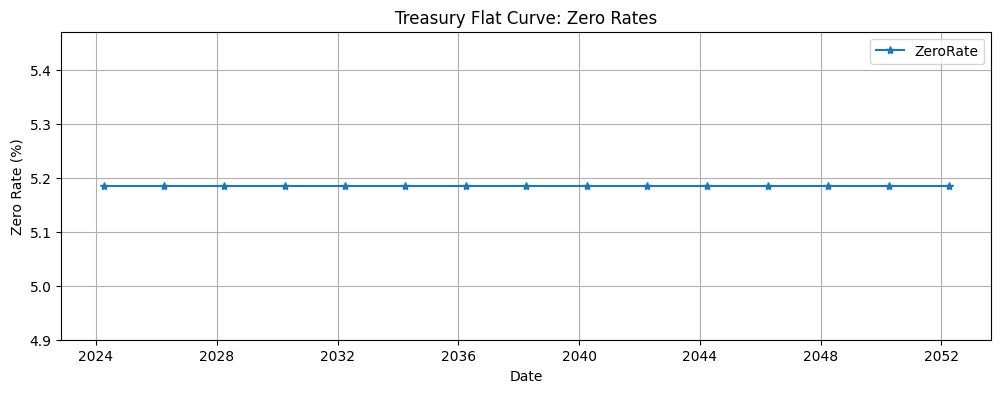

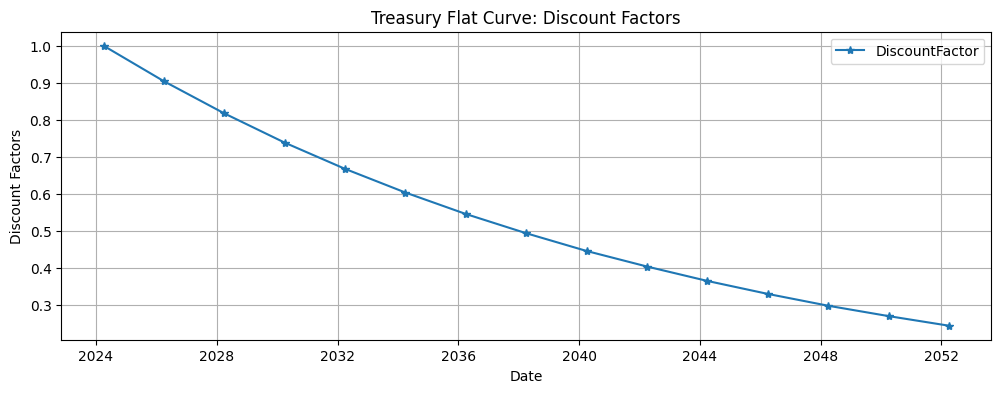

In [129]:
plt = tsy_flat_yield_curve_details_df.plot(x='Date', y='ZeroRate', grid=True, style='*-', title='Treasury Flat Curve: Zero Rates', figsize=(12,4))
plt.set_ylabel('Zero Rate (%)')
plt.set_xlabel('Date')

plt = tsy_flat_yield_curve_details_df.plot(x='Date', y='DiscountFactor', grid=True, style='*-', title='Treasury Flat Curve: Discount Factors', figsize=(12,4))
plt.set_ylabel('Discount Factors')
plt.set_xlabel('Date')

## d. Reprice the bond on the yield curve to validate the calibration 



In [130]:
# 1. Price risk-free bond
risk_free_bond_engine = ql.DiscountingBondEngine(tsy_yield_curve_handle)

fixed_rate_bond.setPricingEngine(risk_free_bond_engine)
risk_free_bond_price = fixed_rate_bond.cleanPrice()
risk_free_bond_yield = fixed_rate_bond.bondYield(risk_free_bond_price, day_counter, compounding, coupon_freq, settle_date) * 100

print('tsy_clean_price_quote:', tsy_clean_price_quote)
print('risk_free_bond_price:', risk_free_bond_price)
print('price_calibration_error:', risk_free_bond_price-tsy_clean_price_quote)
print('risk_free_bond_yield:', risk_free_bond_yield)


tsy_clean_price_quote: 96.0
risk_free_bond_price: 96.0
price_calibration_error: 0.0
risk_free_bond_yield: 5.119227409362794
